# Plots for mutation-transmissibility paper

This notebook generates plots for the [paper/](paper/) directory. This assumes you've alread run
```sh
make update        # ~10 minutes on CPU (mostly sequence alignment)
python mutrans.py  # ~2 hours on GPU
```

In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import pretty_print, pearson_correlation

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load data

In [2]:
%%time
def load_data():
    filename = "results/mutrans.data.single.pt"
    if os.path.exists(filename):
        dataset = torch.load(filename)
    else:
        dataset = mutrans.load_gisaid_data()
        torch.save(dataset, filename)
    dataset.update(mutrans.load_jhu_data(dataset))
    return dataset
dataset = load_data()
locals().update(dataset)
for k, v in sorted(dataset.items()):
    if isinstance(v, torch.Tensor):
        print(f"{k} \t{type(v).__name__} of shape {tuple(v.shape)}")
    else:
        print(f"{k} \t{type(v).__name__} of size {len(v)}")

     3264 Loaded 502 x 3618 daily case data, totaling 206673248.0
     3265 Joining GISAID and JHU region codes
     3567 Matching 942 GISAID regions to 3618 JHU fuzzy regions


daily_cases 	Tensor of shape (502, 942)
features 	Tensor of shape (1280, 2317)
lineage_id 	dict of size 1280
lineage_id_inv 	list of size 1280
local_time 	Tensor of shape (40, 942)
location_id 	OrderedDict of size 942
mutations 	list of size 2317
weekly_cases 	Tensor of shape (40, 942)
weekly_strains 	Tensor of shape (40, 942, 1280)
CPU times: user 730 ms, sys: 209 ms, total: 939 ms
Wall time: 878 ms


In [3]:
print("{} x {} x {} = {}".format(*weekly_strains.shape, weekly_strains.shape.numel()))

40 x 942 x 1280 = 48230400


In [4]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 1820947 samples


Sanity checking case count time series:

In [5]:
if False:
    plt.figure(figsize=(8, 3))
    plt.plot(weekly_cases, lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("confirmed cases");

    plt.figure(figsize=(8, 3))
    plt.plot(weekly_strains.sum(-1), lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("sequenced samples");

In [6]:
locations = set(location_id)
N_usa = sum(1 for k in locations if "/ USA /" in k)
N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
N_other = len(locations) - N_usa - N_uk
print(N_usa, N_uk, N_other)

52 4 886


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [7]:
fits = torch.load("results/mutrans.pt", map_location="cpu")

In [8]:
for key in fits:
    print(key)

('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, ())
('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, (('include', (('location', '^Europe'),)),))
('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, (('exclude', (('location', '^Europe'),)),))


In [9]:
best_fit = list(fits.values())[0]
pretty_print(best_fit, max_items=40)

: dict of length 9
['median']: dict of length 6
['median']['feature_scale']: Tensor of shape ()
['median']['rate_coef_decentered']: Tensor of shape (2317,)
['median']['rate_coef']: Tensor of shape (2317,)
['median']['rate_scale']: Tensor of shape ()
['median']['rate']: Tensor of shape (942, 1280)
['median']['probs']: Tensor of shape (40, 942, 1280)
['mean']: dict of length 6
['mean']['rate_coef_decentered']: Tensor of shape (2317,)
['mean']['probs']: Tensor of shape (40, 942, 1280)
['mean']['rate_coef']: Tensor of shape (2317,)
['mean']['rate']: Tensor of shape (942, 1280)
['mean']['rate_scale']: Tensor of shape ()
['mean']['feature_scale']: Tensor of shape ()
['std']: dict of length 6
['std']['rate_coef_decentered']: Tensor of shape (2317,)
['std']['probs']: Tensor of shape (40, 942, 1280)
['std']['rate_coef']: Tensor of shape (2317,)
['std']['rate']: Tensor of shape (942, 1280)
['std']['rate_scale']: Tensor of shape ()
['std']['feature_scale']: Tensor of shape ()
['losses']: list of 

Scale `rate_coef` by 1/100 in all results.

In [10]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"rate_coef", "rate_bias"}, scale=0.01, prefix=""):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}")
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits)

.('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, ()).median.rate_coef
.('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, ()).mean.rate_coef
.('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, ()).std.rate_coef
.('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, (('include', (('location', '^Europe'),)),)).median.rate_coef
.('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, (('include', (('location', '^Europe'),)),)).mean.rate_coef
.('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, (('include', (('location', '^Europe'),)),)).std.rate_coef
.('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, (('exclude', (('location', '^Europe'),)),)).median.rate_coef
.('reparam-biased', 'feature_scale=0.05', 'custom', 10001, 0.05, 0.1, 10.0, 10, (('exclude', (('location', '^Europe'),)),)).mean.rate_coef
.('r


## Assess model fitness

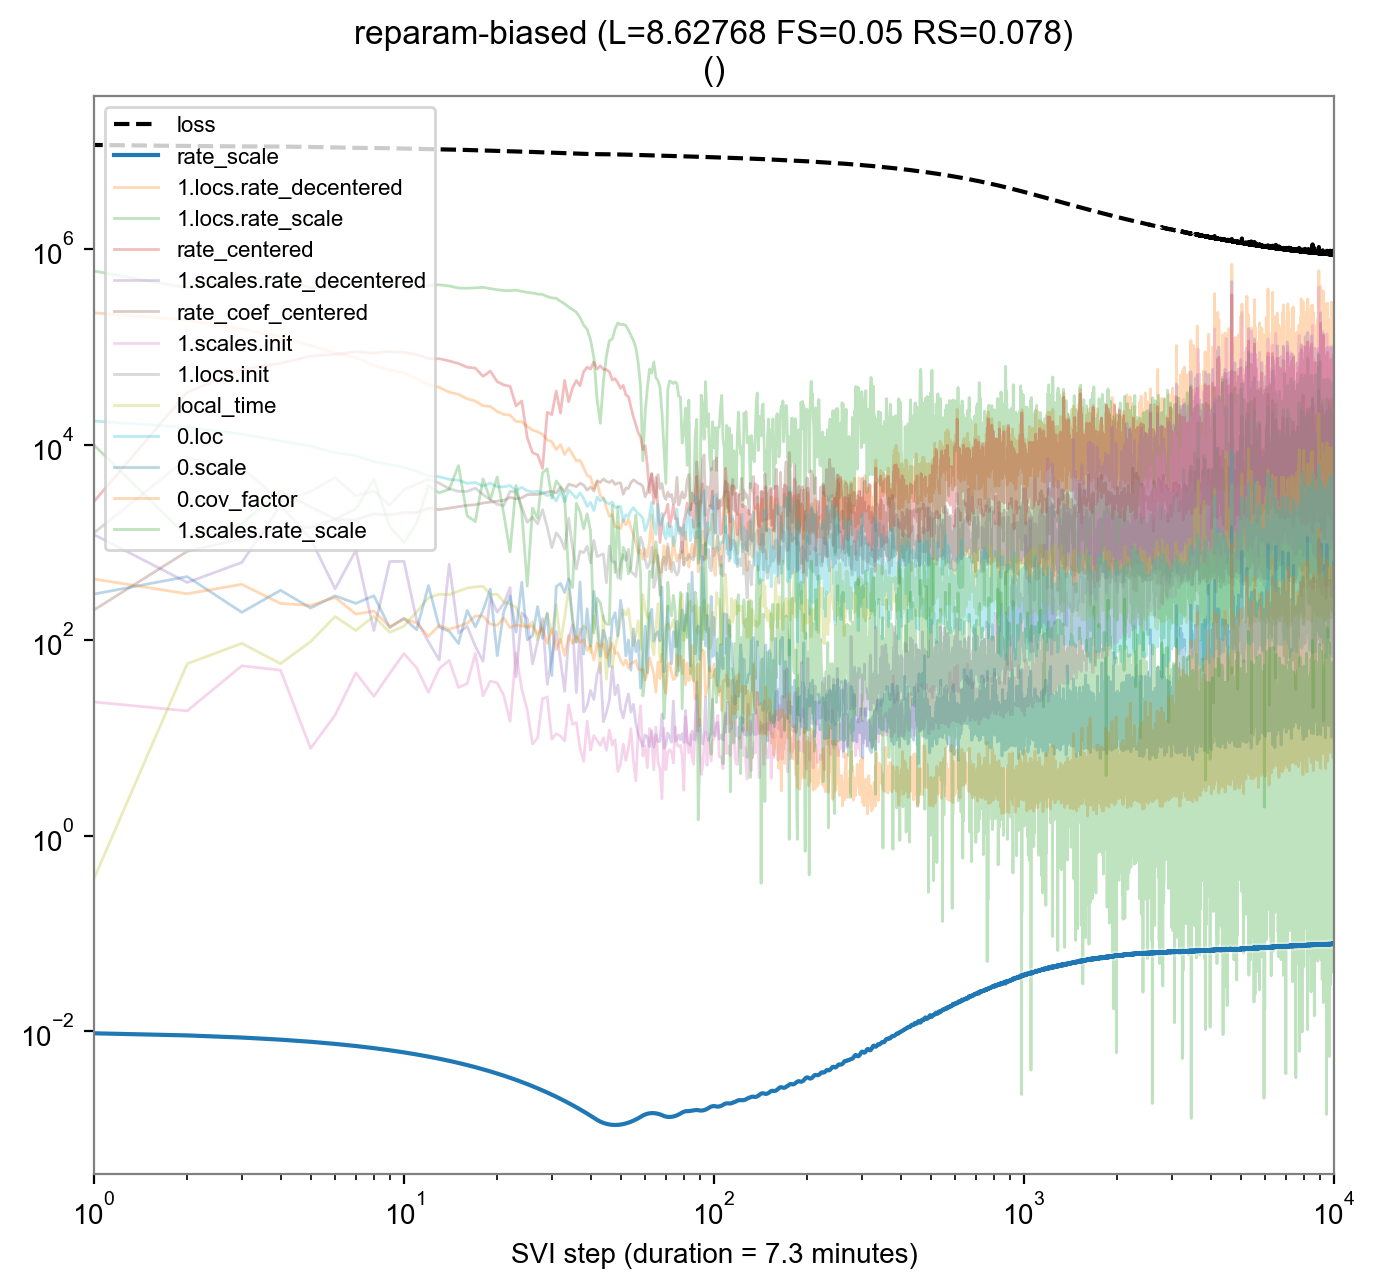

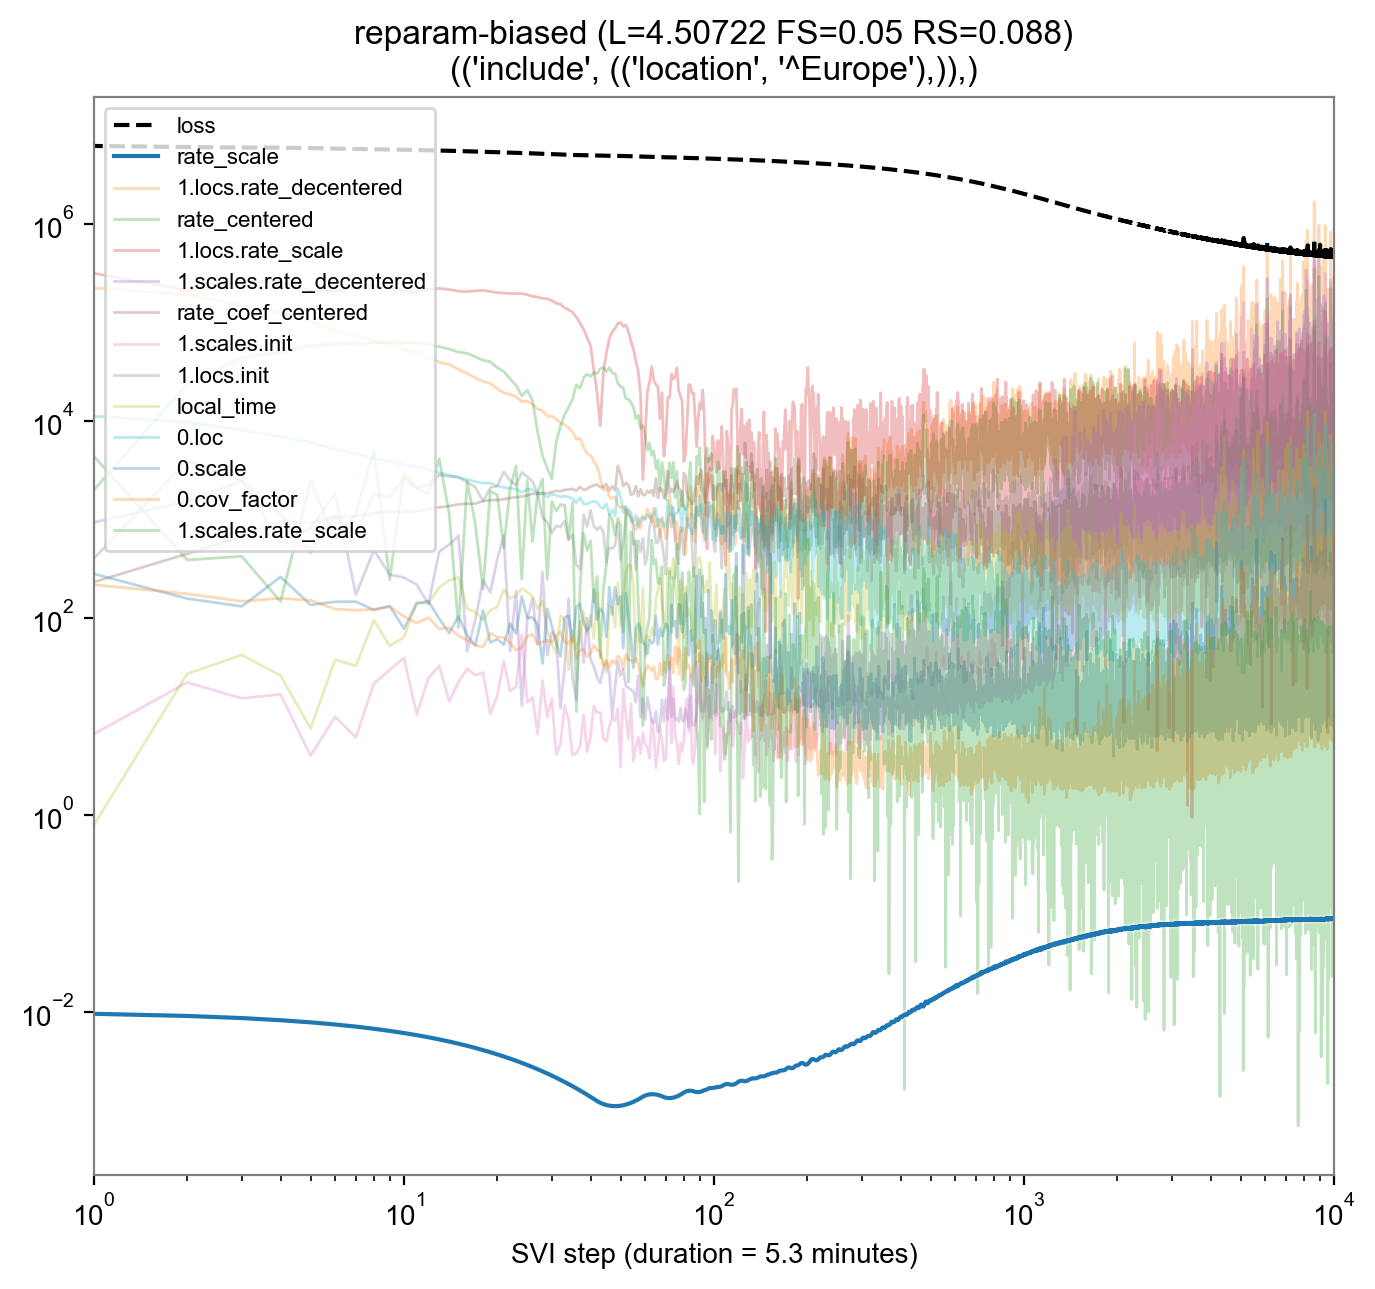

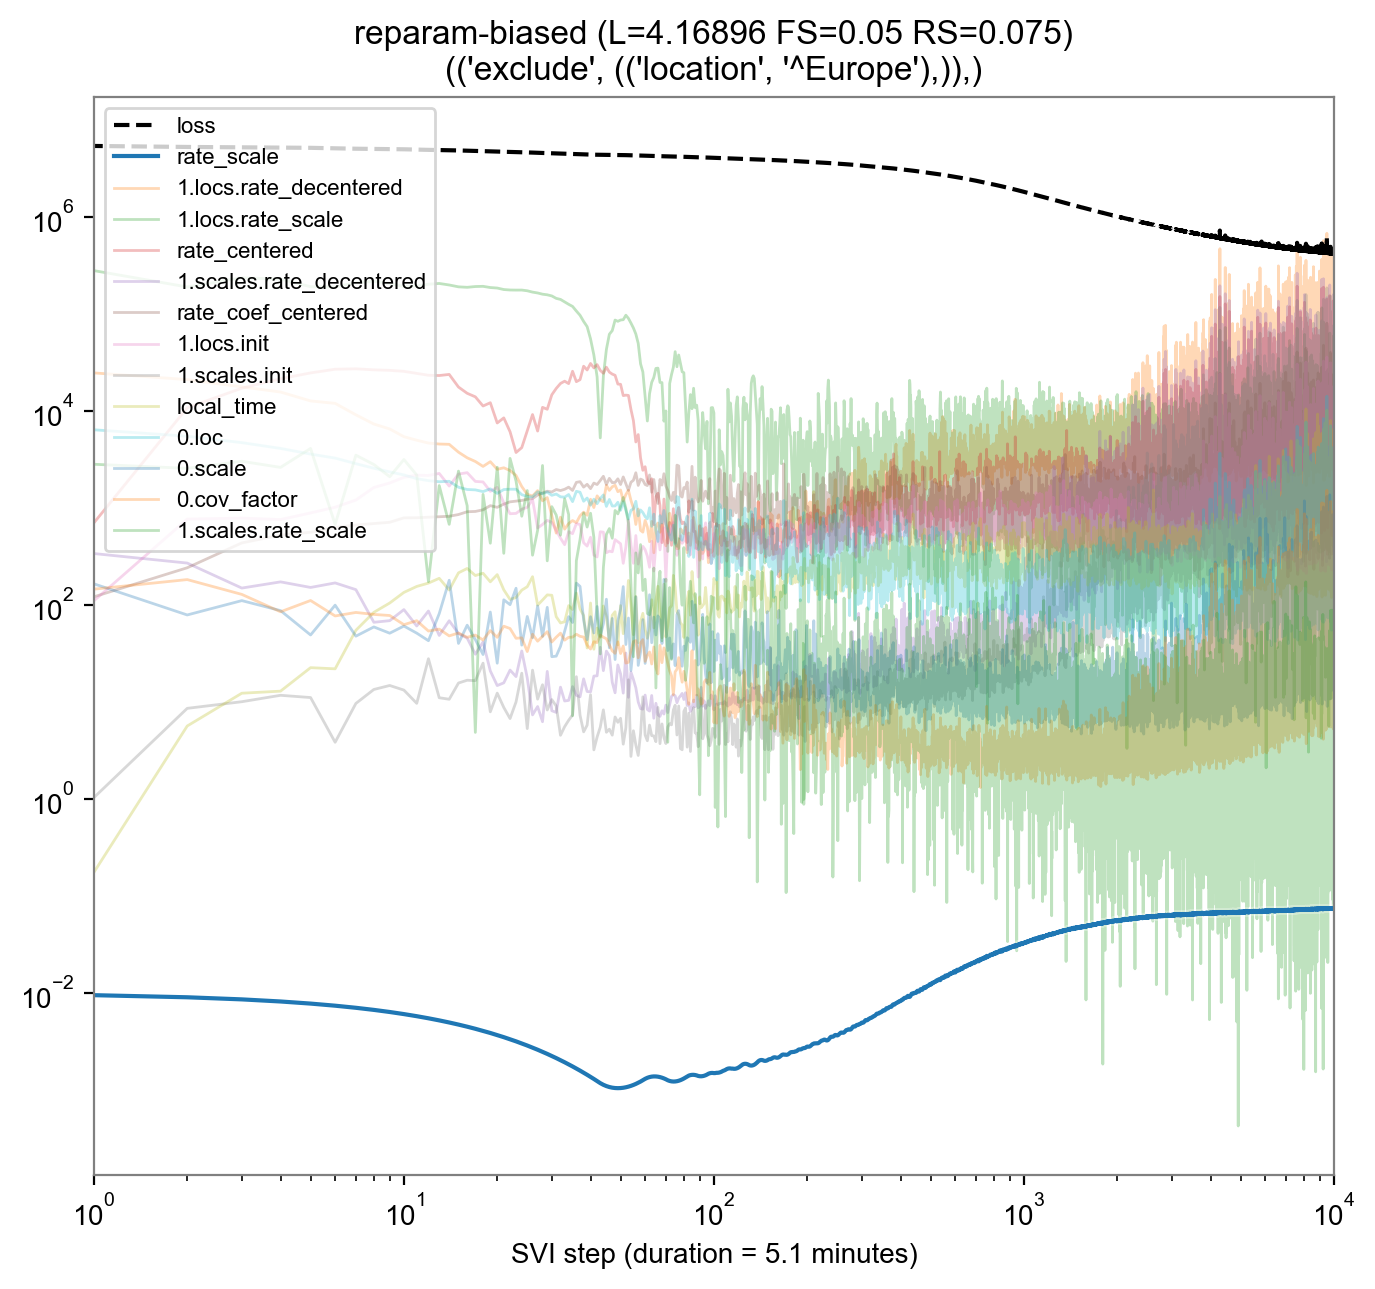

In [11]:
def plot_fits():
    num_nonzero = int(torch.count_nonzero(weekly_strains))
    for key, fit in fits.items():
        median = fit.get("median", fit.get("mean", {}))
        plt.figure(figsize=(8, 7))
        time = np.arange(1, 1 + len(fit["losses"]))
        plt.plot(fit["losses"], "k--", label="loss")
        locs = []
        grads = []
        for name, series in fit["series"].items():
            rankby = -torch.tensor(series).log1p().mean().item()
            if name.startswith("Guide."):
                name = name[len("Guide."):].replace("$$$", ".")
                grads.append((name, series, rankby))
            elif name.endswith("_centered") or name == "local_time":
                grads.append((name, series, rankby))
            elif name != "loss":
                locs.append((name, series, rankby))
        locs.sort(key=lambda x: x[-1])
        grads.sort(key=lambda x: x[-1])
        for name, series, _ in locs:
            plt.plot(time, series, label=name)
        for name, series, _ in locs:
            plt.plot(time, series, color="white", lw=3, alpha=0.3, zorder=-1)
        for name, series, _ in grads:
            plt.plot(time, series, lw=1, alpha=0.3, label=name, zorder=-2)
        plt.yscale("log")
        plt.xscale("log")
        plt.xlim(1, len(fit["losses"]))
        plt.legend(loc="upper left", fontsize=8)
        plt.xlabel("SVI step (duration = {:0.1f} minutes)".format(fit["walltime"]/60))
        loss = np.median(fit["losses"][-201:]) / num_nonzero
        scalars = " ".join([f"L={loss:0.6g}"] + [
            "{}={:0.3g}".format(
                "".join(p[0] for p in k.split("_")).upper(), v
            )
            for k, v in median.items()
            if v.numel() == 1
        ])
        plt.title("{} ({})\n{}".format(key[0], scalars, key[-1]))
plot_fits()

## Interpreting results

England matched 1 regions
USA / California matched 1 regions


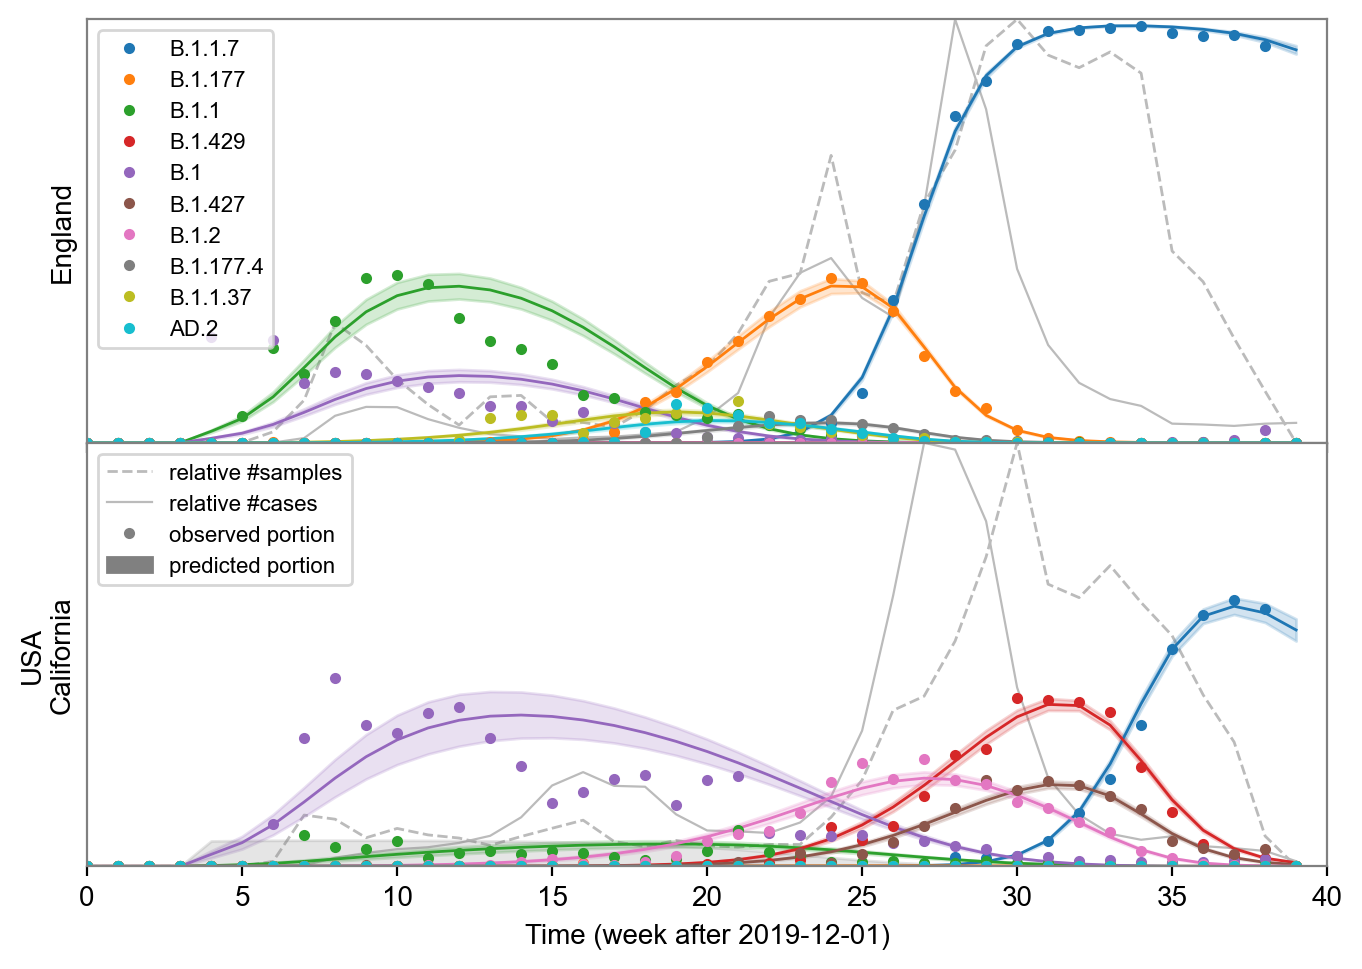

In [12]:
def plusminus(mean, std):
    p95 = 1.96 * std
    return torch.stack([mean - p95, mean, mean + p95])

def plot_forecast(fit, queries=None, num_strains=10, filenames=[]):
    if queries is None:
        queries = list(location_id)
    elif isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1.5 + 2 * len(queries)), sharex=True)
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    probs = plusminus(fit["mean"]["probs"], fit["std"]["probs"])
    predicted = probs * weekly_cases[:, :, None]  # [T, P, S]
    ids = torch.tensor([i for name, i in location_id.items()
                        if any(q in name for q in queries)])
    strain_ids = weekly_strains[:, ids].sum([0, 1]).sort(-1, descending=True).indices
    strain_ids = strain_ids[:num_strains]
    colors = [f"C{i}" for i in range(10)] + ["black"] * 90
    assert len(colors) >= num_strains
    light = "#bbbbbb"
    for row, (query, ax) in enumerate(zip(queries, axes)):
        ids = torch.tensor([i for name, i in location_id.items() if query in name])
        print(f"{query} matched {len(ids)} regions")
        counts = weekly_cases[:, ids].sum(1)
        counts /= counts.max()
        ax.plot(counts, "k-", color=light, lw=0.8, zorder=-20)
        counts = weekly_strains[:, ids].sum([1, 2])
        counts /= counts.max()
        ax.plot(counts, "k--", color=light, lw=1, zorder=-20)
        pred = predicted.index_select(-2, ids).sum(-2)
        pred /= pred[1].sum(-1, True).clamp_(min=1e-8)
        obs = weekly_strains[:, ids].sum(1)
        obs /= obs.sum(-1, True).clamp_(min=1e-9)
        time = np.arange(len(local_time))
        for s, color in zip(strain_ids, colors):
            lb, mean, ub = pred[..., s]
            ax.fill_between(time, lb, ub, color=color, alpha=0.2, zorder=-10)
            ax.plot(mean, color=color, lw=1, zorder=-9)
            strain = lineage_id_inv[s]
            ax.plot(obs[:, s], color=color, lw=0, marker='o', markersize=3,
                    label={"Q": "B.1.1.7"}.get(strain, strain) if row == 0 else None)
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(query.replace(" / ", "\n"))
        ax.set_xlim(0, len(weekly_strains))
        if row == len(axes) - 1:
            ax.set_xlabel("Time (week after 2019-12-01)")
        if row == 0:
            ax.legend(loc="upper left", fontsize=8)
        elif row == 1:
            ax.plot([], "k--", color=light, lw=1, label="relative #samples")
            ax.plot([], "k-", color=light, lw=0.8, label="relative #cases")
            ax.plot([], lw=0, marker='o', markersize=3, color='gray',
                    label="observed portion")
            ax.fill_between([], [], [], color='gray', label="predicted portion")
            ax.legend(loc="upper left", fontsize=8)
    plt.subplots_adjust(hspace=0)
    for filename in filenames:
        plt.savefig(filename)

plot_forecast(best_fit,
              queries=["England", "USA / California"],
              num_strains=10,
              filenames=["paper/forecast.png"])

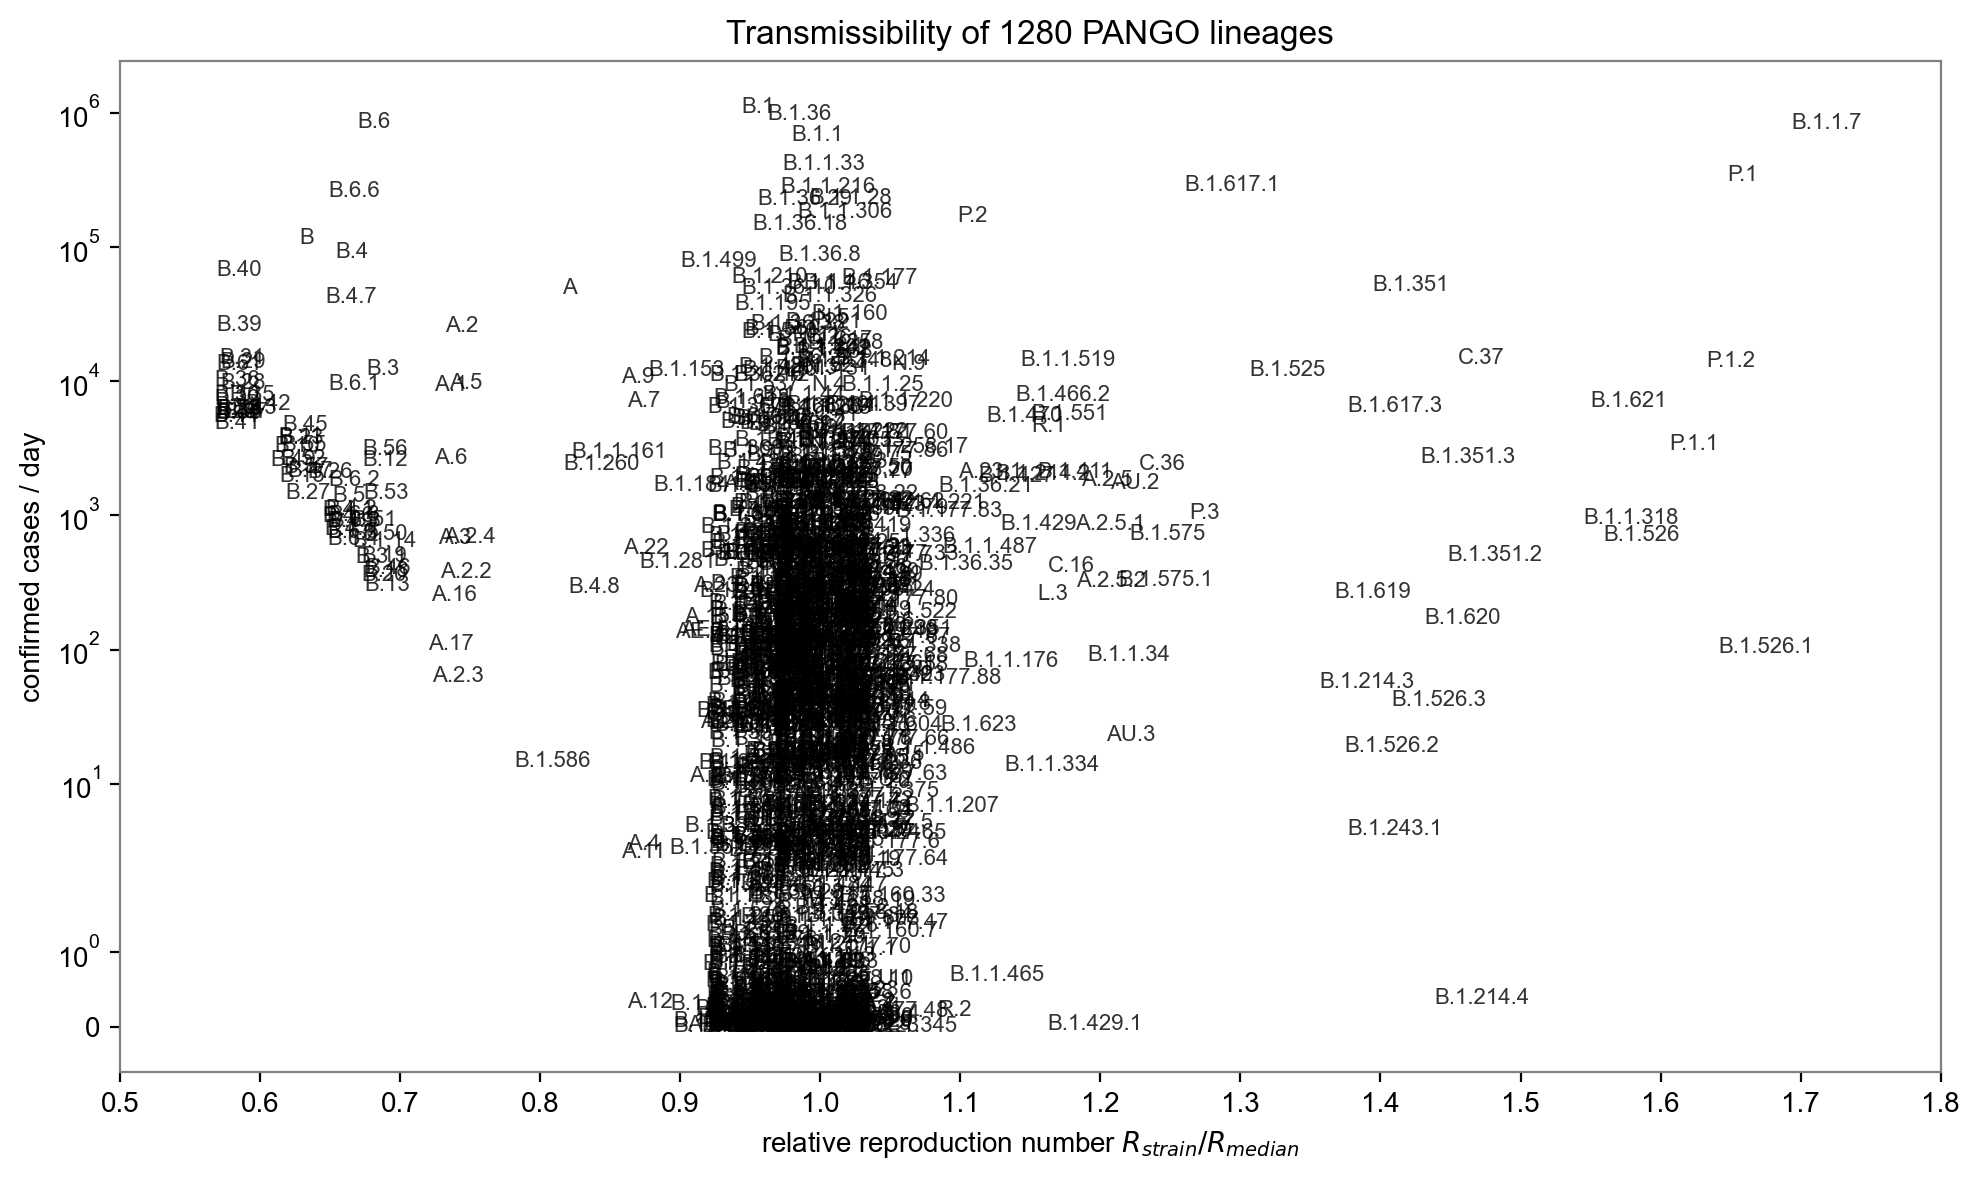

In [13]:
def plot_prevalence(fit, filenames=()):
    rate = fit["median"]["rate"]
    if rate.dim() == 2:
        rate = rate.median(0).values
    rate = rate - rate.median()
    R = rate.exp()
    probs = fit["median"]["probs"].mean(0)
    cases = torch.einsum("ps,p->s", probs, weekly_cases[-2])
    cases = cases / mutrans.TIMESTEP
    plt.figure(figsize=(10, 6))
    plt.scatter(R, cases, lw=0, alpha=0)
    for name, i in lineage_id.items():
        plt.text(R[i], cases[i], name, fontsize=8, alpha=0.8,
                 horizontalalignment="center", verticalalignment="center",)
    plt.ylabel("confirmed cases / day")
    plt.yscale("symlog")
    #plt.xscale("log")
    #plt.ylim(1, None)
    plt.xlim(0.9, None)
    lb10 = math.floor(10 * R.min().item())
    ub10 = math.ceil(10 * R.max().item())
    xticks = [x10 / 10 for x10 in range(lb10, ub10 + 1)]
    plt.xticks(xticks, list(map(str, xticks)))
    plt.xlabel("relative reproduction number $R_{strain} / R_{median}$")
    plt.title(f"Transmissibility of {len(lineage_id)} PANGO lineages")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)

plot_prevalence(best_fit, ["paper/strain_prevalence.png"])

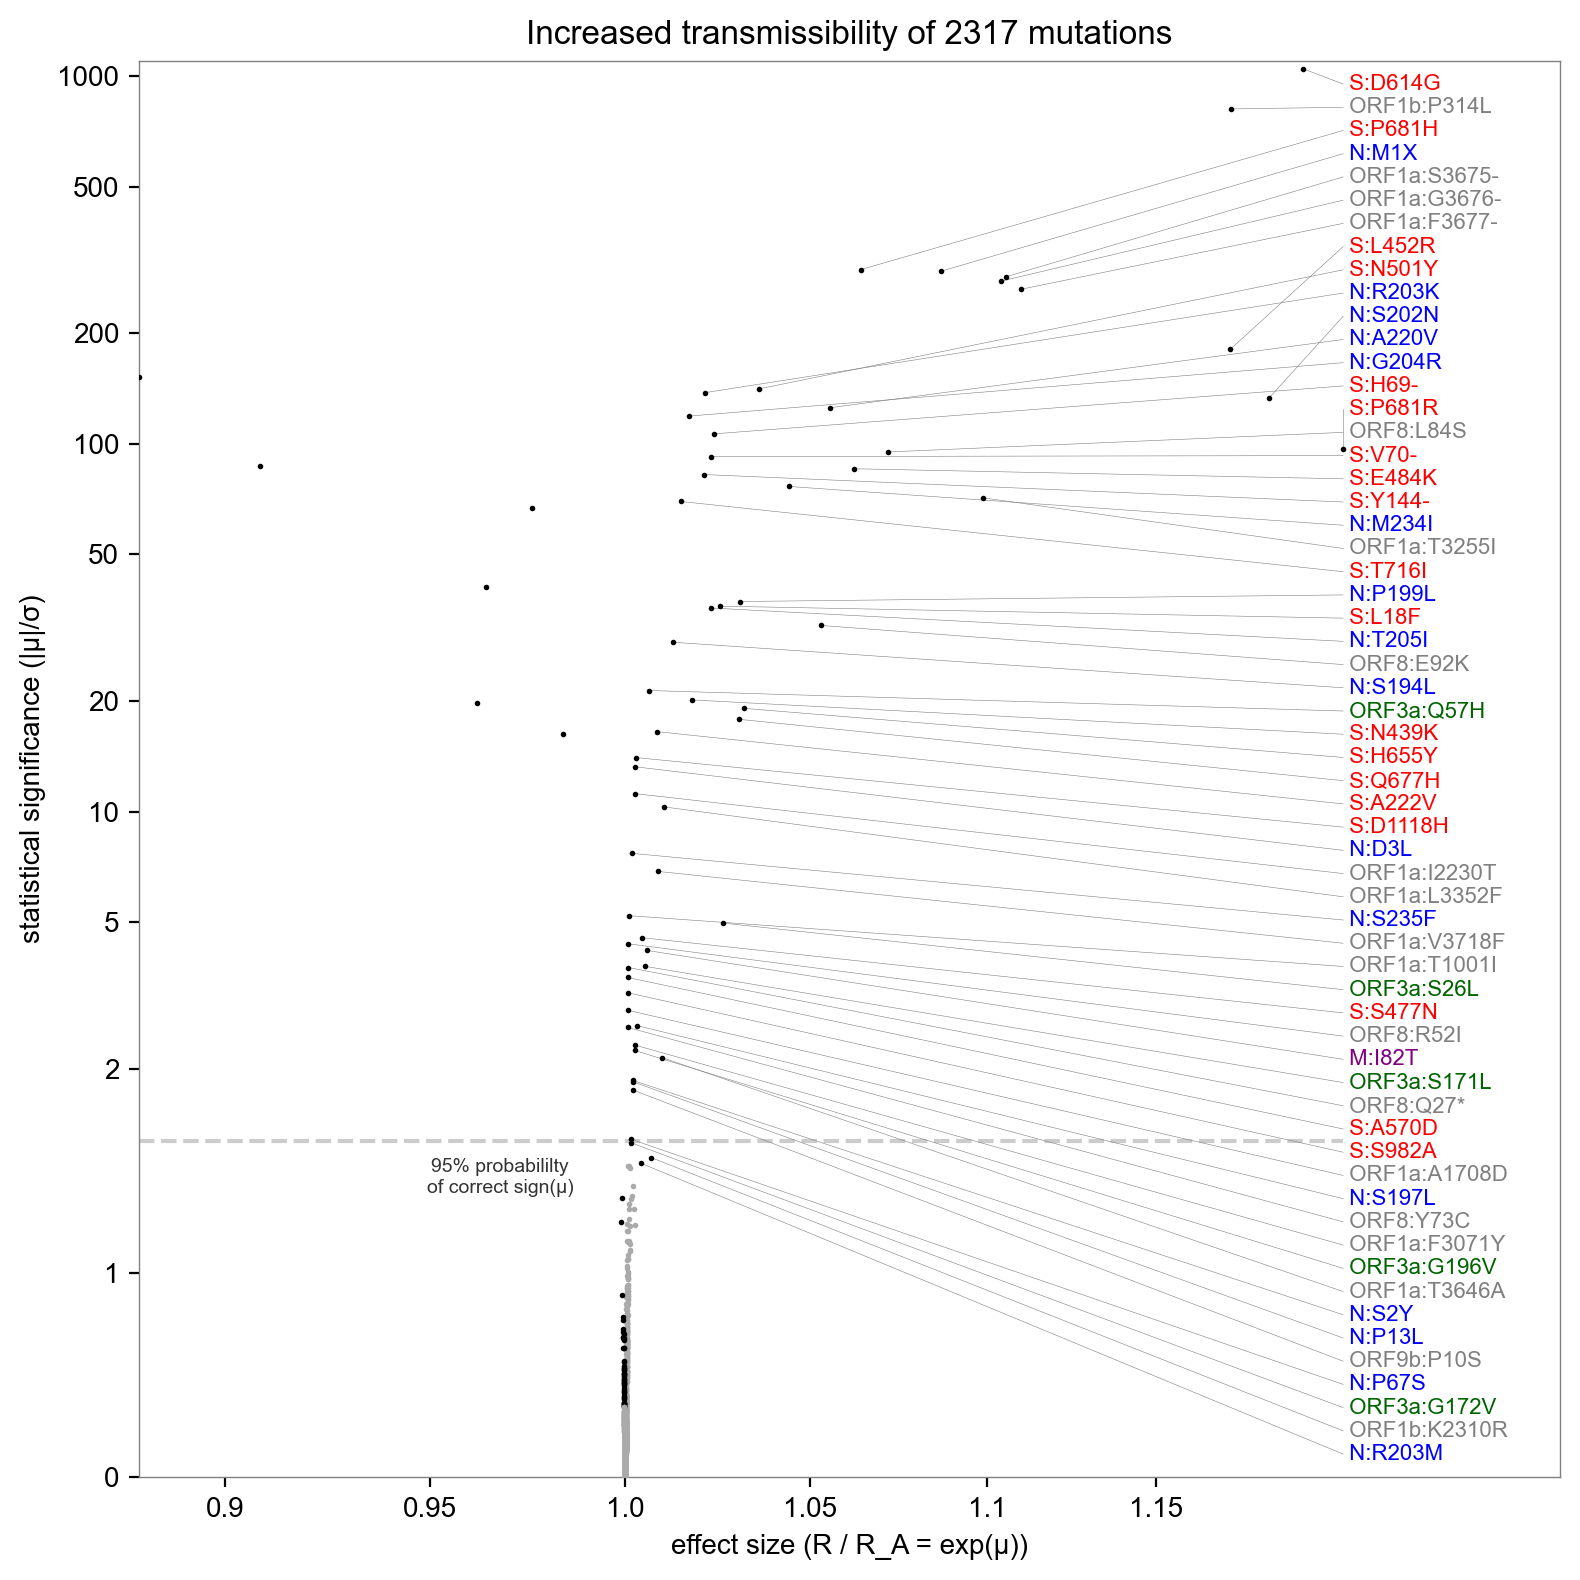

In [14]:
def plot_volcano(mean, std, filenames=(), linthresh=2, top_k=60, plot_neg=False):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = top_k

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("effect size (R / R_A = exp(μ))")
    xticks = [0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
    plt.xticks(list(map(math.log, xticks)), list(map(str, xticks)))
    plt.ylabel("statistical significance (|μ|/σ)")
    if plot_neg:
        lpad = 0.33 if any("," in mutations[i] for i in idx_neg[:N].tolist()) else 0.18
    else:
        lpad = 0
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.18
    plt.xlim(x0 - (x1 - x0) * lpad, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    plt.plot([x0, x1], [p95, p95], 'k--', alpha=0.2)
    comment_pos = 0.8 if plot_neg else 0.3
    plt.text((1 - comment_pos) * x0 + comment_pos * x1, p95 * 0.95,
             "95% probabililty\nof correct sign(μ)",
             fontsize=7, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF3a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    if plot_neg:
        for i in range(min(N, len(xs_neg))):
            x = x0
            _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
            plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='gray', lw=0.2)
            name = mutations[int(idx_neg[i])]
            plt.text(x, y, name + " ", color=colors.get(name.split(":")[0], "gray"),
                     fontsize=8, verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

plot_volcano(best_fit["mean"]["rate_coef"], best_fit["std"]["rate_coef"], linthresh=2,
             filenames=["paper/volcano.png"])

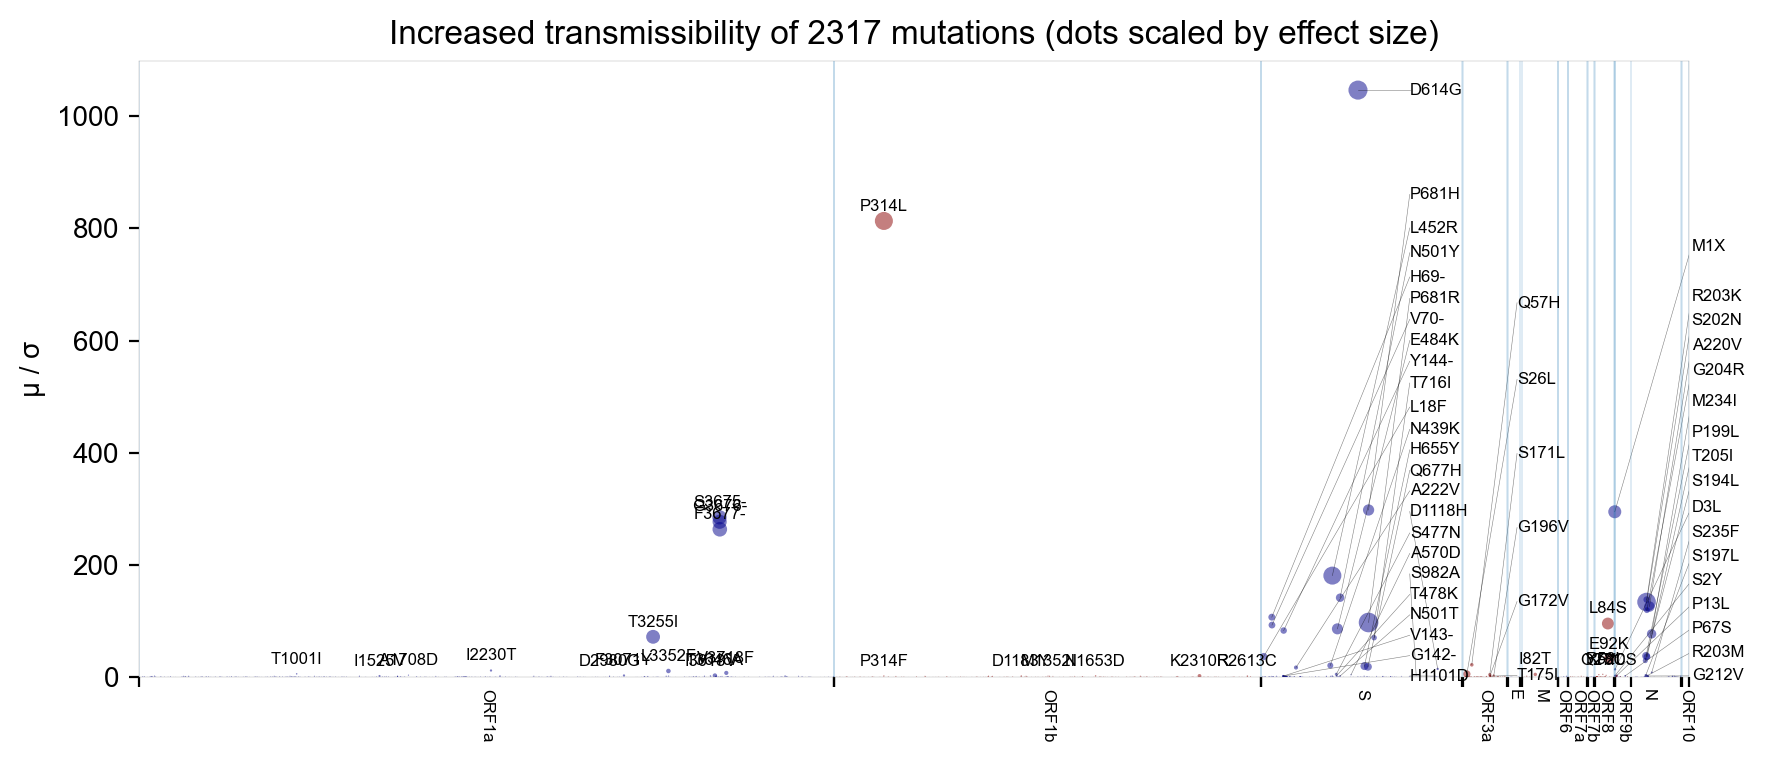

In [15]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, std, top_k=75, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(10, 4))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots scaled by effect size)")
    mean_scale = 50 / mean.max().item()
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), sigma[mask].numpy(),
                    mean_scale * mean[mask].numpy(), color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items() if v}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
        y_label = 0.2 * y + 0.8 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in ["N", "ORF3a"]:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
            y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("μ / σ")
    for f in filenames:
        plt.savefig(f)

plot_manhattan(best_fit["mean"]["rate_coef"], best_fit["std"]["rate_coef"],
               filenames=["paper/manhattan.png"])

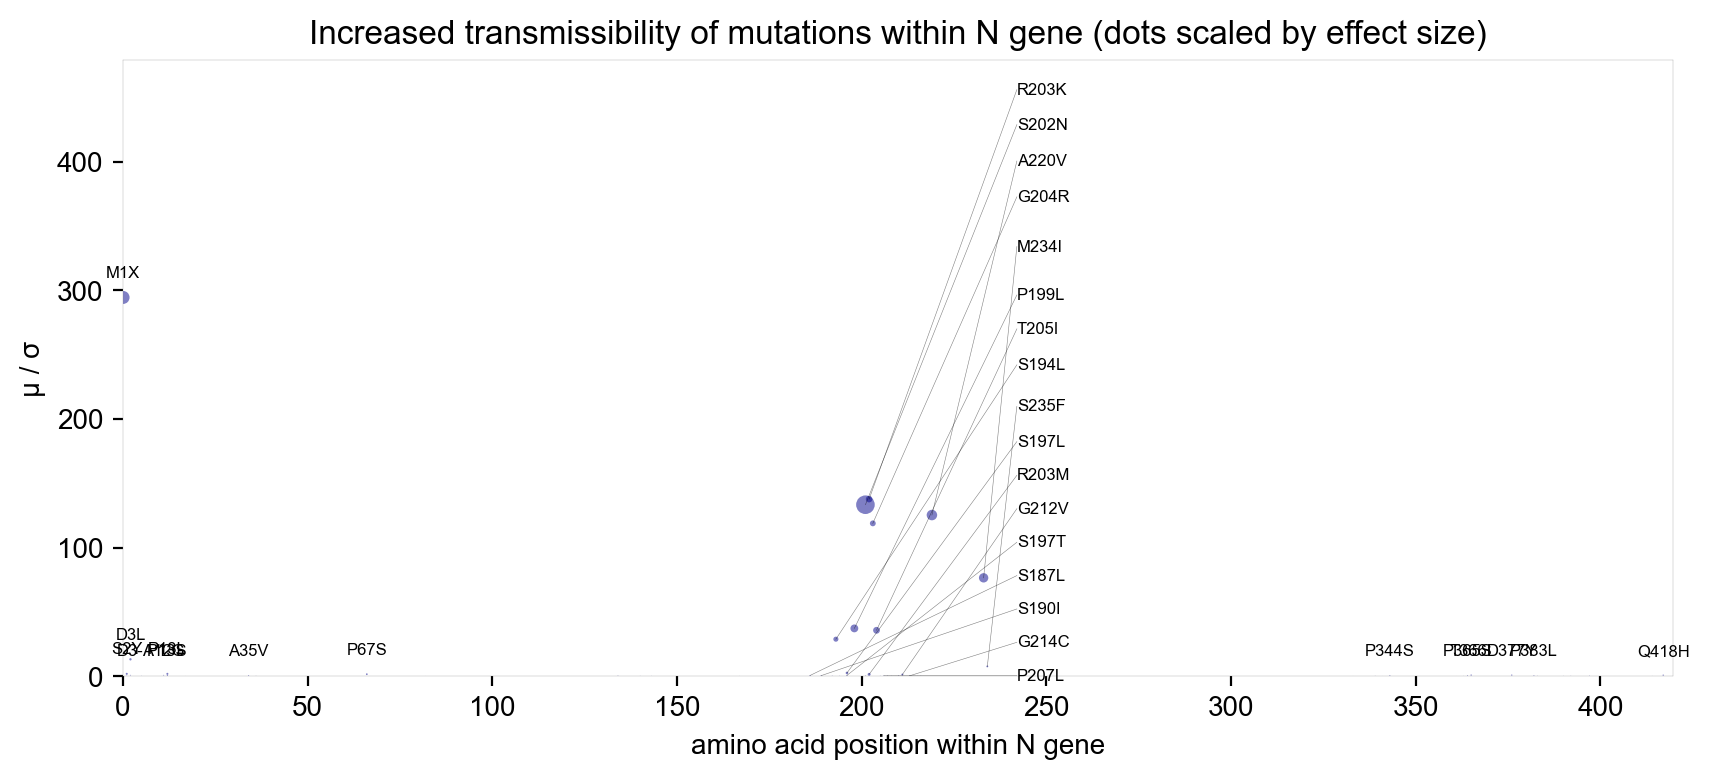

In [16]:
def plot_upper_east_side(mean, std, top_k=120, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    mask = (gene_ids == gene_id["N"]) & (mean > 0)

    plt.figure(figsize=(10, 4))
    plt.title(f"Increased transmissibility of mutations within N gene"
              " (dots scaled by effect size)")
    mean_scale = 50 / mean.max().item()
    plt.scatter(position[mask].numpy(), sigma[mask].numpy(),
                mean_scale * mean[mask].numpy(), color="darkblue", alpha=0.5, lw=0)
    special = []  # Many hits, plot with lines
    z0 = 28800
    z1 = 29000
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene != "N":
            continue
        if z0 < x < z1:
            special.append((y, x, name))
        else:
            plt.text(x, y + y1/80, name, fontsize=6,
                     verticalalignment="bottom", horizontalalignment="center")
    special.sort(reverse=True)
    lb = min(y for (y, _, _) in special)
    ub = max(y for (y, _, _) in special)
    lb, ub = lb * 0.5, ub * 0.5 + y1 * 0.5
    for i, (y, x, name) in enumerate(special):
        y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special) - 0.99)))
        x_label = z1
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    start, end = GENE_TO_POSITION["N"]
    plt.xlim(start, end)
    xticks = [start]
    while xticks[-1] + 150 < end:
        xticks.append(xticks[-1] + 150)
    labels = [str((x - start) // 3) for x in xticks]
    plt.xticks(xticks, labels)
    plt.xlabel("amino acid position within N gene")
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("μ / σ")
    for f in filenames:
        plt.savefig(f)

plot_upper_east_side(best_fit["mean"]["rate_coef"], best_fit["std"]["rate_coef"],
                     filenames=["paper/upper_east_side.png"], top_k=250)

## Extracting a table of top mutations and their stories

In [17]:
def rank_mutations(fit, names):
    mean = fit["mean"]["rate_coef"]
    std = fit["std"]["rate_coef"]
    sigma = mean / std.clamp(min=1e-8)
    ranks = sigma.sort(0, descending=True).indices.tolist()
    assert len(ranks) == len(mutations)
    ranked = [mutations[k] for k in ranks]
    ranks = {m: i for i, m in enumerate(ranked)}
    print("Mut'n\tRank\tEstimate")
    for name in names:
        i = mutations.index(name)
        print("{}\t{}\t{:0.3g} ± {:0.2g}".format(name, ranks[name], mean[i], std[i]))

rank_mutations(best_fit, ["S:D614G", "S:N501Y", "S:E484K", "S:L452R"])

Mut'n	Rank	Estimate
S:D614G	0	0.178 ± 0.00017
S:N501Y	8	0.0354 ± 0.00025
S:E484K	17	0.0602 ± 0.0007
S:L452R	7	0.159 ± 0.00088


In [18]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [19]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [20]:
def write_mutation_table(fit, filename):
    assert filename.endswith(".tsv")
    mean = fit["mean"]["rate_coef"]
    std = fit["std"]["rate_coef"]
    sigma = mean / std.clamp(min=1e-8)
    if "samples" in fit:
        lb, ub = stats.confidence_interval(0.95, fit["samples"]["rate_coef"])
    else:
        lb, ub = dist.Normal(mean, std).icdf(torch.tensor([0.025, 0.975])[:, None])
    R_RA = mean.exp()  # mean is in units of generation time.
    lineage_counts = weekly_strains.sum((0, 1))
    schema = [
        ("rank", "{:d}"),
        ("mutation", "{:s}"),
        ("mean/stddev", "{:0.6g}"),
        ("mean", "{:0.6g}"),
        ("95% ci lower", "{:0.6g}"),
        ("95% ci upper", "{:0.6g}"),
        ("R / R_A", "{:0.6g}"),
        ("emerged in lineages", "{:s}"),  
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(sigma.sort(0, descending=True).indices.tolist()):
            emerged = find_emergences(i)
            f.write(row.format(
                rank + 1, mutations[i],
                sigma[i], mean[i], lb[i], ub[i], R_RA[i], ", ".join(emerged)
            ))

write_mutation_table(best_fit, "paper/mutations.tsv")
pd.read_csv("paper/mutations.tsv", sep="\t")

rank      mutation  mean/stddev      mean  95% ci lower  95% ci upper  \
0        1       S:D614G    1046.8200  0.178426      0.178092      0.178760   
1        2   ORF1b:P314L     813.3580  0.159620      0.159235      0.160004   
2        3       S:P681H     297.5990  0.062110      0.061701      0.062519   
3        4         N:M1X     294.4220  0.083168      0.082614      0.083722   
4        5  ORF1a:S3675-     284.5510  0.100364      0.099673      0.101056   
...    ...           ...          ...       ...           ...           ...   
2312  2313   ORF1b:A440V     -19.7369 -0.038989     -0.042861     -0.035117   
2313  2314  ORF1a:L3606F     -40.8085 -0.036633     -0.038393     -0.034874   
2314  2315   ORF1a:T265I     -66.7391 -0.024453     -0.025171     -0.023734   
2315  2316   ORF1a:D448-     -86.7470 -0.096033     -0.098203     -0.093863   
2316  2317   ORF3a:G251V    -152.0280 -0.128107     -0.129759     -0.126456   

       R / R_A                                emerged in lineages  
0     1.195330         A.18, A.19, A.2.5, B.1, B.4.8, B.59, B.6.7  
1     1.173060                                   B.1, B.59, B.6.7  
2     1.064080  B.1.1.207, P.3 (B.1.1.28.3), B.1.1.318, B.1.1....  
3     1.086720  C.36 (B.1.1.1.36), P.3 (B.1.1.28.3), R.1 (B.1....  
4     1.105570  C.37 (B.1.1.1.37), B.1.1.176, P.1 (B.1.1.28.1)...  
...        ...                                                ...  
2312  0.961762  B.1.1.190, B.1.1.267, B.1.1.269, B.1.13, B.1.2...  
2313  0.964030  B, C.22 (B.1.1.1.22), C.34 (B.1.1.1.34), C.8 (...  
2314  0.975844  B.1.1.335, B.1.1.38, B.1.108, B.1.115, B.1.116...  
2315  0.908434  C.23 (B.1.1.1.23), B.10, B.11, B.15, B.23, B.2...  
2316  0.879759                                                  B  

[2317 rows x 8 columns]

In [21]:
print(columns.keys())

dict_keys(['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day'])


In [22]:
def estimate_lineage_bdays(exclude_first=10):
    lineage_days = defaultdict(list)
    for lineage, day in zip(columns["lineage"], columns["day"]):
        lineage = pangolin.decompress(lineage)
        lineage_days[lineage].append(day)
    lineage_bday = {}
    for lineage, days in list(lineage_days.items()):
        days.sort()
        lineage_bday[lineage] = days[min(exclude_first, len(days) // 10)]
    start_date = datetime.datetime.strptime(mutrans.START_DATE, "%Y-%m-%d")
    return {
        lineage: (start_date + datetime.timedelta(days=day)).strftime("%Y-%m-%d")
        for lineage, day in lineage_bday.items()
    }

lineage_bday = estimate_lineage_bdays()

In [23]:
def write_strain_table(fit, filename):
    assert filename.endswith(".tsv")
    rate_mean = fit["mean"]["rate"].mean(0)
    rate_std = (fit["std"]["rate"].mean(0) ** 2 + fit["mean"]["rate"].std(0) ** 2).sqrt()
    R_mean = rate_mean.exp()
    lb, ub = dist.Normal(rate_mean, rate_std).icdf(torch.tensor([0.025, 0.975])[..., None])
    RA = R_mean[lineage_id["A"]].item()
    R_RA = R_mean / RA
    probs = fit["median"]["probs"]
    cases = torch.einsum("tps,tp->ts", probs, weekly_cases)
    cases_per_day = cases[-2] / mutrans.TIMESTEP
    cases_total = cases.sum(0)
    schema = [
        ("rank", "{:d}"),
        ("strain", "{:s}"),
        ("R / R_A", "{:.6g}"),
        ("95% ci lower", "{:.6g}"),
        ("95% ci upper", "{:.6g}"),
        ("confirmed cases / day", "{:.6g}"),
        ("confirmed cases total", "{:.6g}"),
        ("birthday", "{:s}"),
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(R_RA.sort(0, descending=True).indices.tolist()):
            lineage = lineage_id_inv[i]
            f.write(row.format(
                rank + 1, lineage,
                R_RA[i], lb[i], ub[i], cases_per_day[i], cases_total[i],
                lineage_bday[pangolin.decompress(lineage)],
            ))

write_strain_table(best_fit, "paper/strains.tsv")
pd.read_csv("paper/strains.tsv", sep="\t")

rank     strain   R / R_A  95% ci lower  95% ci upper  \
0        1        P.1  2.045250      0.737690      1.056200   
1        2  B.1.526.1  2.031640      0.731387      1.049150   
2        3    B.1.1.7  2.011880      0.656523      1.104460   
3        4      P.1.2  2.010280      0.722063      1.037340   
4        5      P.1.1  1.980880      0.697740      1.032190   
...    ...        ...       ...           ...           ...   
1275  1276       B.30  0.707056     -0.316300     -0.014139   
1276  1277       B.36  0.706940     -0.316425     -0.014344   
1277  1278       B.44  0.706772     -0.317037     -0.014208   
1278  1279       B.39  0.706522     -0.312971     -0.018982   
1279  1280       B.40  0.704672     -0.313456     -0.023739   

      confirmed cases / day  confirmed cases total    birthday  
0              1.600180e+06            174883000.0  2020-12-06  
1              1.050850e+03                49132.5  2020-12-28  
2              3.941300e+06            474380000.0  2020-04-17  
3              1.108580e+05              6712910.0  2021-02-24  
4              2.044230e+04              3821890.0  2021-02-01  
...                     ...                    ...         ...  
1275           6.732870e-13               260089.0  2020-03-16  
1276           5.200750e-13               154661.0  2020-03-17  
1277           3.840030e-13               180457.0  2020-03-17  
1278           7.212350e-13               264860.0  2020-03-06  
1279           5.997810e-07               338233.0  2020-02-18  

[1280 rows x 8 columns]

## Comparison with deep mutational scans

We first compare with [(Starr et al. 2020)](https://www.sciencedirect.com/science/article/pii/S0092867420310035) who study S mutations affecting folding and ACE2 binding.

In [24]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S0092867420310035-mmc2.csv")
df

site_RBD  site_SARS2 wildtype mutant mutation mutation_RBD  bind_lib1  \
0            1         331        N      A    N331A          N1A      -0.05   
1            1         331        N      C    N331C          N1C      -0.08   
2            1         331        N      D    N331D          N1D       0.00   
3            1         331        N      E    N331E          N1E       0.02   
4            1         331        N      F    N331F          N1F      -0.03   
...        ...         ...      ...    ...      ...          ...        ...   
4216       201         531        T      T    T531T        T201T       0.00   
4217       201         531        T      V    T531V        T201V       0.03   
4218       201         531        T      W    T531W        T201W       0.02   
4219       201         531        T      Y    T531Y        T201Y       0.00   
4220       201         531        T      *    T531*        T201*        NaN   

      bind_lib2  bind_avg  expr_lib1  expr_lib2  expr_avg  
0         -0.02     -0.03      -0.14      -0.08     -0.11  
1         -0.10     -0.09      -1.56      -0.97     -1.26  
2          0.07      0.03      -0.75      -0.12     -0.44  
3         -0.02      0.00      -0.39      -0.24     -0.31  
4         -0.16     -0.10      -0.83      -0.57     -0.70  
...         ...       ...        ...        ...       ...  
4216       0.00      0.00       0.00       0.00      0.00  
4217      -0.02      0.01      -0.07      -0.05     -0.06  
4218      -0.06     -0.02      -0.13      -0.04     -0.08  
4219      -0.03     -0.01      -0.03      -0.08     -0.05  
4220        NaN       NaN      -4.59      -4.51     -4.55  

[4221 rows x 12 columns]

In [25]:
folding = {f"S:{m}": float(e) for m, e in zip(df["mutation"], df["expr_avg"])}
binding = {f"S:{m}": float(b) for m, b in zip(df["mutation"], df["bind_avg"])}
print(sum(1 for m in mutations if m in folding))

36


We next compare with [(Greaney et al. 2021)](https://www.sciencedirect.com/science/article/pii/S1931312820306247) who study antibody escape.

In [26]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S1931312820306247-mmc2.csv")
df

condition  site wildtype mutation  mut_escape  site_total_escape  \
0      COV2-2050   331        N        A    0.000366            0.03350   
1      COV2-2050   331        N        C    0.001012            0.03350   
2      COV2-2050   331        N        D    0.000373            0.03350   
3      COV2-2050   331        N        E    0.005233            0.03350   
4      COV2-2050   331        N        F    0.001505            0.03350   
...          ...   ...      ...      ...         ...                ...   
23591    rCR3022   531        T        R    0.004248            0.08231   
23592    rCR3022   531        T        S    0.003195            0.08231   
23593    rCR3022   531        T        V    0.004409            0.08231   
23594    rCR3022   531        T        W    0.005216            0.08231   
23595    rCR3022   531        T        Y    0.003794            0.08231   

       site_max_escape  
0             0.005233  
1             0.005233  
2             0.005233  
3             0.005233  
4             0.005233  
...                ...  
23591         0.006145  
23592         0.006145  
23593         0.006145  
23594         0.006145  
23595         0.006145  

[23596 rows x 7 columns]

In [27]:
escape = {
    f"S:{w}{s}{m}": float(e)
    for w, s, m, e in zip(df["wildtype"], df["site"], df["mutation"], df["mut_escape"])
}
print(sum(1 for m in mutations if m in escape))

36


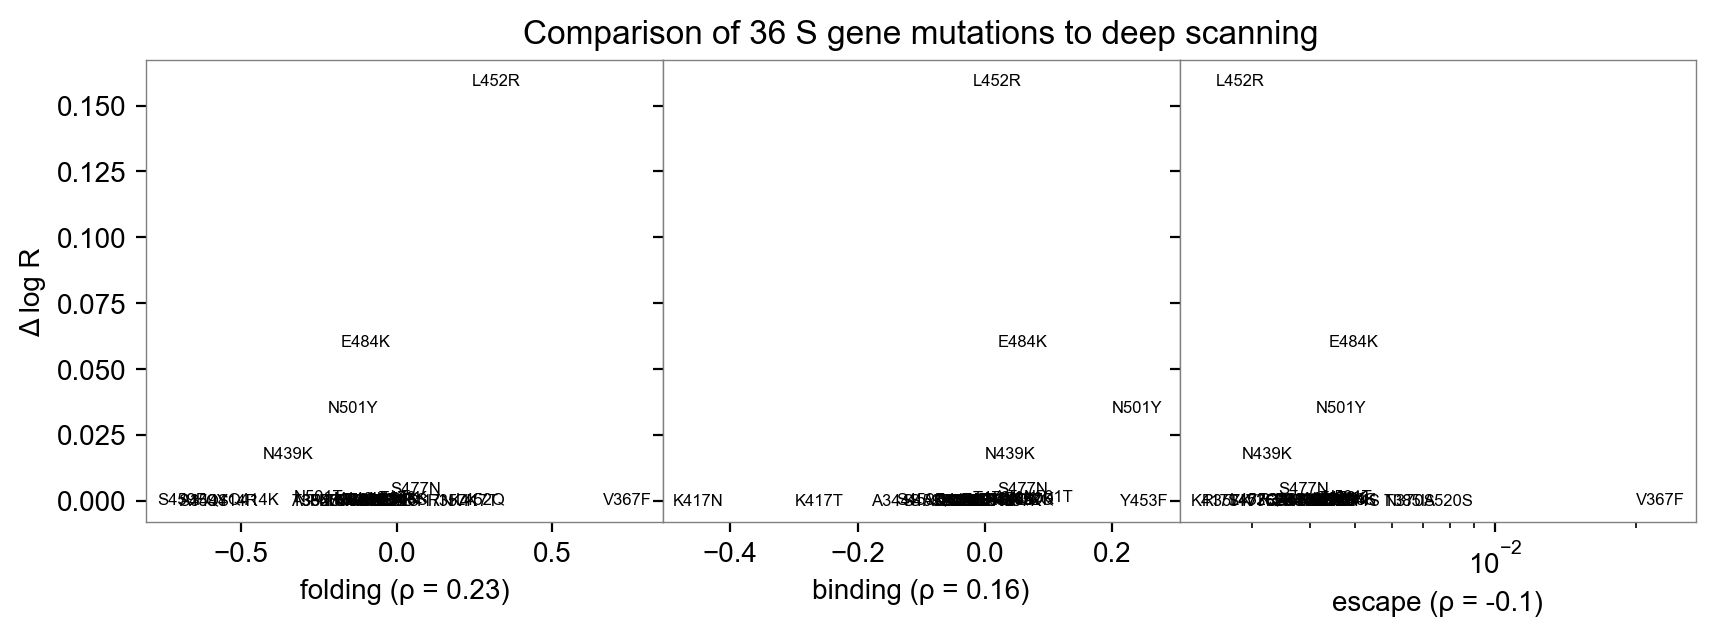

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ms = [m for m in mutations if m in escape]
y = best_fit["mean"]["rate_coef"][[i for i, m in enumerate(mutations) if m in escape]].numpy()
axes[0].set_ylabel("Δ log R")
for name, ax in zip(["folding", "binding", "escape"], axes):
    scan = locals()[name]
    x = torch.tensor([scan[m] for m in ms]).numpy()
    # ax.scatter(x, y, alpha=0.5, lw=0)
    for xm, ym, m in zip(x, y, ms):
        ax.text(xm, ym, m[2:], fontsize=6,
                verticalalignment="center", horizontalalignment="center")
    ax.set_xlim(1.08 * x.min() - 0.08 * x.max(), 1.08 * x.max() - 0.08 * x.min())
    ax.set_ylim(1.05 * y.min() - 0.05 * y.max(), 1.05 * y.max() - 0.05 * y.min())
    ax.set_xlabel(f"{name} (ρ = {pearson_correlation(x, y):0.2g})")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
axes[2].set_xscale("log")
axes[2].set_xlim(x.min() ** 1.08 / x.max() ** 0.08, x.max() ** 1.08 / x.min() ** 0.08)
axes[1].set_title(f"Comparison of {len(ms)} S gene mutations to deep scanning")
plt.subplots_adjust(wspace=0)

It's hard to say whether these correlations are meaningful, as they are dominated by a few outliers.

Let's fit a linear model regressing transmissibility against theses deep scanning results.

In [29]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.optim import Adam

def fit_model(fit):
    trans_data = fit["mean"]["rate_coef"][[i for i, m in enumerate(mutations) if m in escape]]
    folding_data = torch.tensor([folding[m] for m in ms])
    binding_data = torch.tensor([binding[m] for m in ms])
    escape_data = torch.tensor([escape[m] for m in ms])
    
    def model():
        coef = pyro.sample("coef", dist.Normal(0, 10).expand([5]).to_event(1))
        t, f, b, e, be = coef.unbind(-1)
        noise = pyro.sample("noise", dist.LogNormal(0, 2))
        with pyro.plate("data", len(trans_data)):
            pred = (
                t + f * folding_data + b * binding_data + e * escape_data
                + be * binding_data * escape_data
            )
            pyro.sample("trans", dist.Normal(pred, noise), obs=trans_data)

    pyro.clear_param_store()
    guide = AutoMultivariateNormal(model)
    elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
    svi = SVI(model, guide, Adam({"lr": 0.2}), elbo)
    for step in range(201):
        loss = svi.step()
        if step % 20 == 0:
            print(f"step {step} loss = {loss:0.4g}")
    loc, scale = guide._loc_scale()
    print("Model:")
    print("transmissibility = t + f folding + b binding + e escape + be binding escape")
    print("Learned coefficients:")
    for k, l, s in zip("t f b e be".split(), loc.tolist(), scale.tolist()):
        print(f"{k} = {l:0.4g} +- {s:0.2f}")
        
fit_model(best_fit)

    29102 Guessed max_plate_nesting = 2


step 0 loss = 342
step 20 loss = 102.6
step 40 loss = 77.88
step 60 loss = 40.73
step 80 loss = -1.842
step 100 loss = -27.45
step 120 loss = -47.53
step 140 loss = -31.84
step 160 loss = -29.97
step 180 loss = -51.61
step 200 loss = -50.92
Model:
transmissibility = t + f folding + b binding + e escape + be binding escape
Learned coefficients:
t = 0.01844 +- 0.01
f = 0.04972 +- 0.02
b = -0.008592 +- 0.07
e = -1.873 +- 0.91
be = -0.2375 +- 7.37


## Fit on subsets of data

In [30]:
print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "North America " in n]).most_common(2))
print(Counter([n for n in columns["location"] if "Europe " in n]).most_common(2))

[('hCoV-19/USA/KS-CDC-2-3693594/2020', 1), ('hCoV-19/USA/KS-CDC-2-3693489/2020', 1)]
[('North America / USA / Texas / Houston', 37333), ('North America / USA / Florida', 31281)]
[('Europe / United Kingdom / England', 346691), ('Europe / United Kingdom / Scotland', 43553)]
[('North America / USA / Texas / Houston', 37333), ('North America / USA / Florida', 31281)]
[('Europe / United Kingdom / England', 346691), ('Europe / Denmark / Hovedstaden', 48311)]


In [31]:
holdout_fits = {k[-1]: v for k, v in fits.items() if k[-1]}
for key in holdout_fits:
    print(key[-1])

('include', (('location', '^Europe'),))
('exclude', (('location', '^Europe'),))


In [32]:
aliases = [
    "full data",
    "only Europe",
    "excluding Europe",
    # "only North America",
    # "excluding North America",
    # "only the USA",
    # "excluding the USA",
    # "excluding the UK",
    # "only the UK",
    # "only CDC data",
    # "only CDC NS3 data",
]
holdout_fits = dict(zip(aliases, [best_fit] + list(holdout_fits.values())))
assert len(holdout_fits) == 3

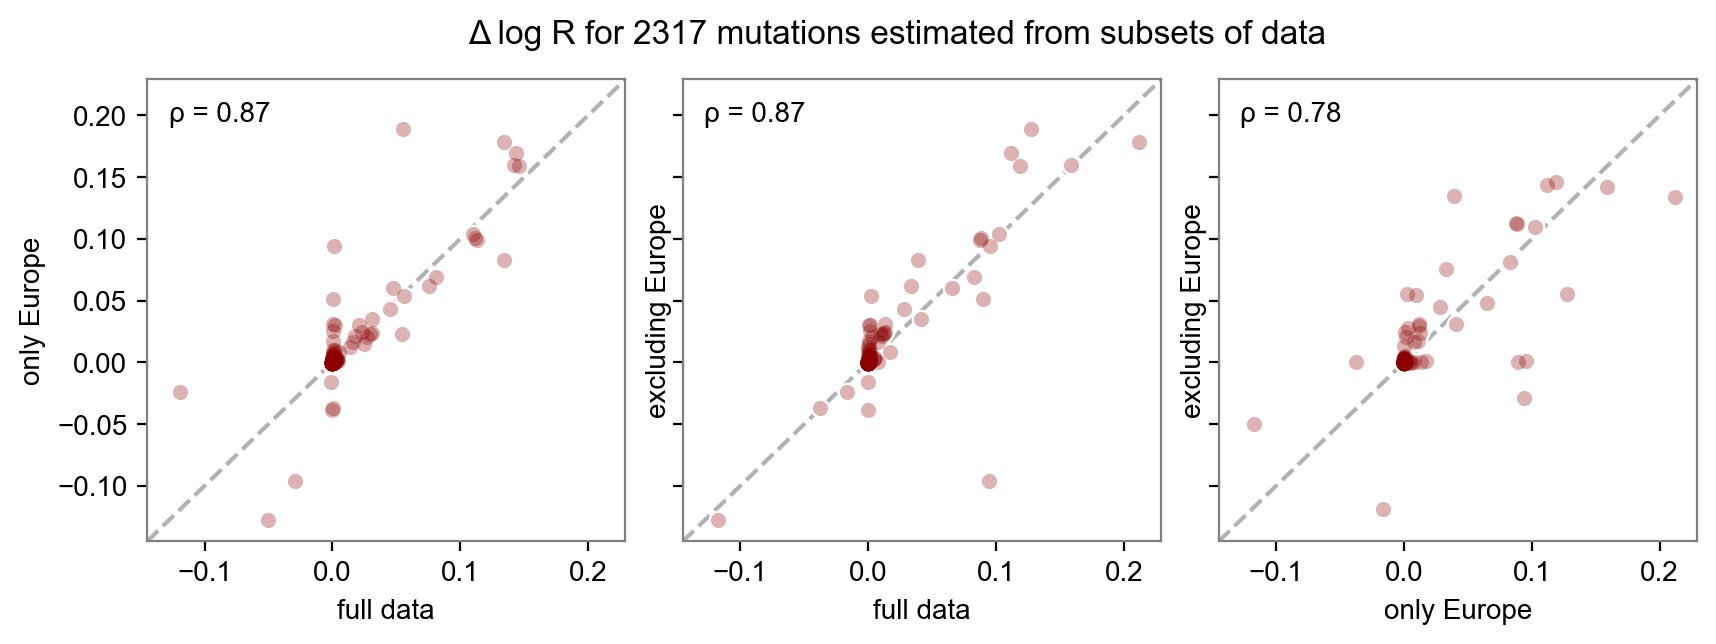

In [33]:
def plot_mutation_agreements(holdouts, filenames=()):
    def get_mean(fit):
        return fit["mean"]["rate_coef"]
    (name0, fit0), (name1, fit1), (name2, fit2) = holdouts.items()
    pairs = [
        [(name0, fit0), (name1, fit1)],
        [(name0, fit0), (name2, fit2)],
        [(name1, fit1), (name2, fit2)],
    ]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in means)
    x1 = max(mean.max().item() for mean in means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig.suptitle("Δ log R for {} mutations estimated from subsets of data"
                 .format(len(list(holdouts.values())[0]["mutations"])))
    for ax, ((name1, fit1), (name2, fit2)) in zip(axes, pairs):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = []
        for fit in (fit1, fit2):
            m_to_i = {m: i for i, m in enumerate(fit["mutations"])}
            idx = torch.tensor([m_to_i[m] for m in mutations])
            means.append(get_mean(fit)[idx])
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 50, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.3, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(pearson_correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_ylim(lb, ub)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
    plt.subplots_adjust(wspace=0.12)
    for f in filenames:
        plt.savefig(f)

plot_mutation_agreements(holdout_fits, ["paper/mutation_agreement.png"])

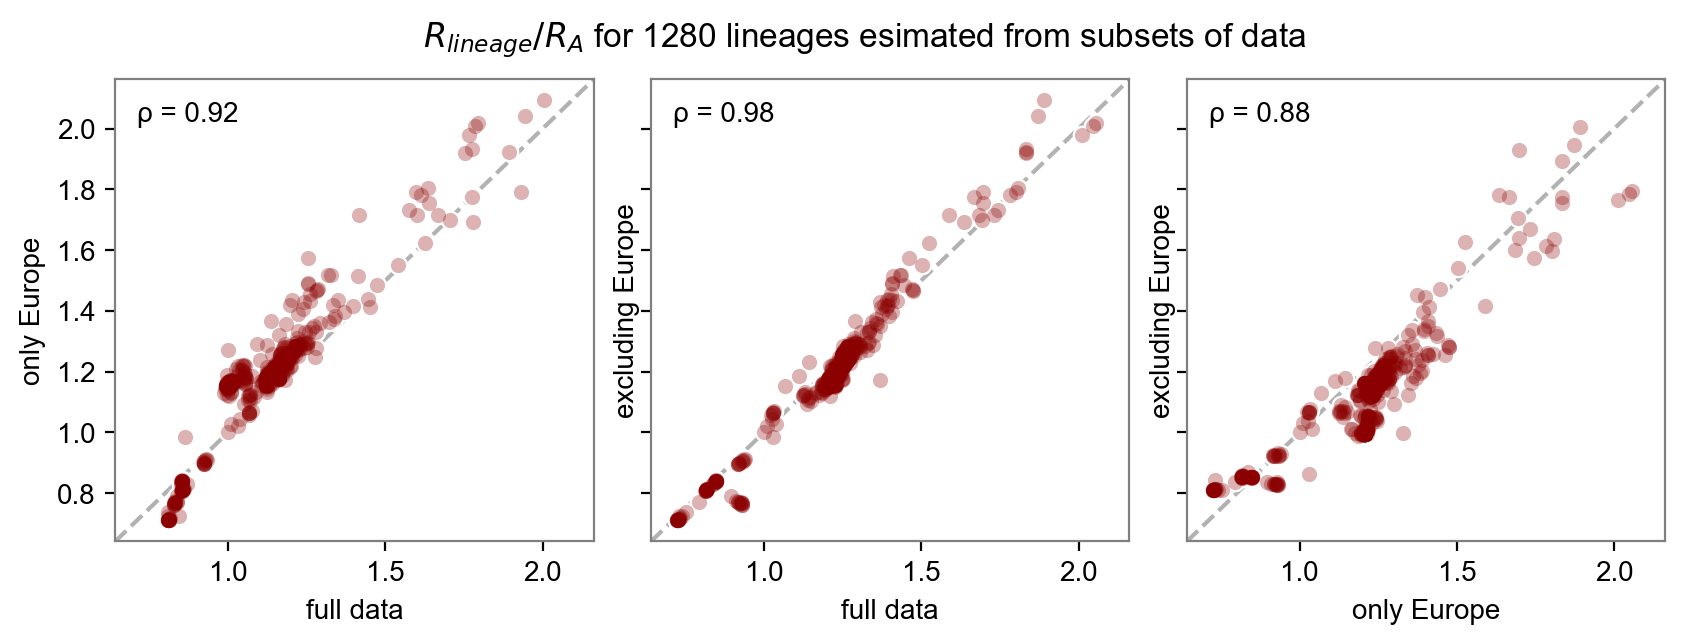

In [34]:
def plot_strain_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        rate = fit["median"]["rate"]
        if rate.dim() == 2:
            rate = rate.median(0).values
        return (rate - rate[lineage_id["A"]]).exp()
    (name0, fit0), (name1, fit1), (name2, fit2) = holdouts.items()
    pairs = [
        [(name0, fit0), (name1, fit1)],
        [(name0, fit0), (name2, fit2)],
        [(name1, fit1), (name2, fit2)],
    ]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in means)
    x1 = max(mean.max().item() for mean in means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig.suptitle("$R_{{lineage}} / R_A$ for {} lineages esimated from subsets of data"
                 .format(len(lineage_id)))
    for ax, ((name1, fit1), (name2, fit2)) in zip(axes, pairs):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = [get_mean(fit) for fit in (fit1, fit2)]
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 50, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.3, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(pearson_correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_ylim(lb, ub)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
    plt.subplots_adjust(wspace=0.12)
    for f in filenames:
        plt.savefig(f)

plot_strain_agreements(best_fit, holdout_fits, ["paper/lineage_agreement.png"])

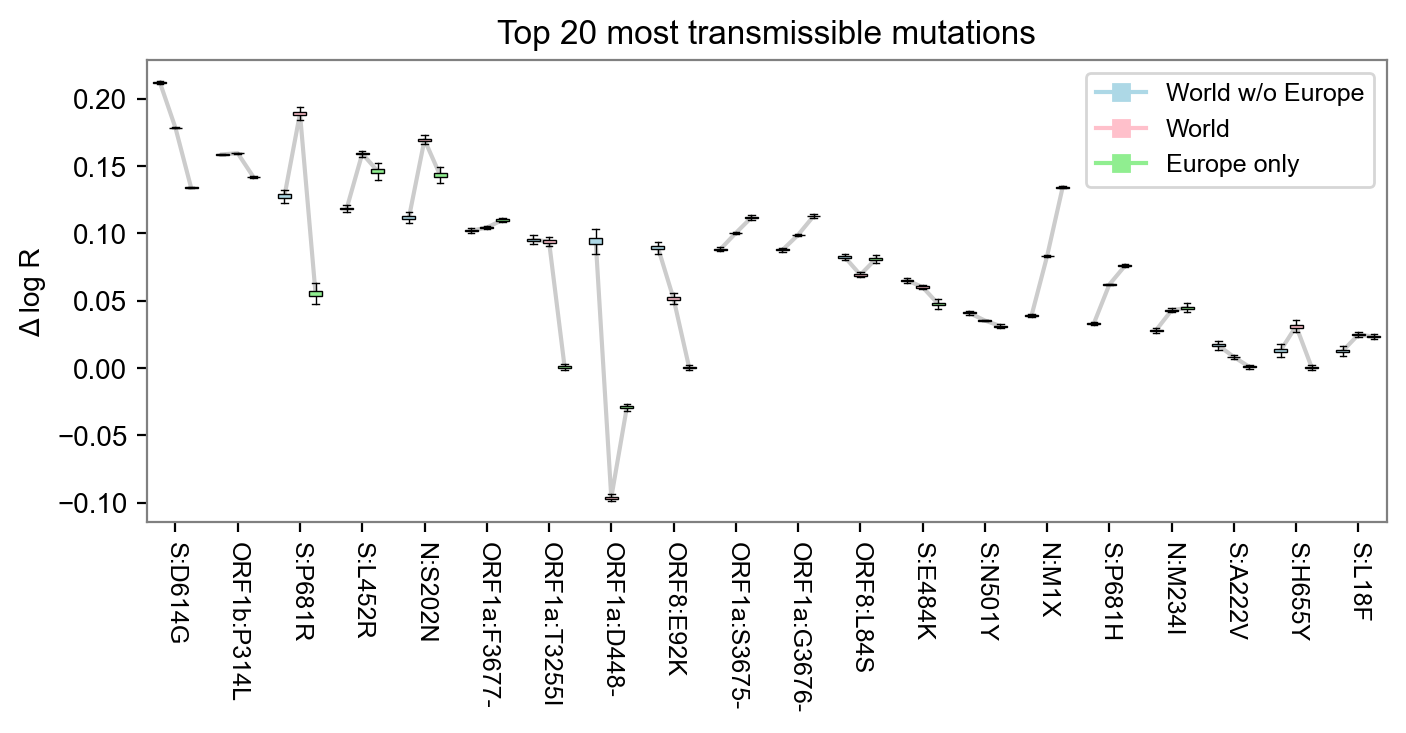

In [35]:
def plot_mutation_subset_boxplot(fits, rankby="t", top_k=20, filenames=()):
    best_fit = next(iter(fits.values()))
    if rankby == "s":
        rankby = best_fit["mean"]["rate_coef"] / best_fit["std"]["rate_coef"]
        title = f"Top {top_k} most statistically significant mutations"
    elif rankby == "t":
        rankby = best_fit["mean"]["rate_coef"]
        title = f"Top {top_k} most transmissible mutations"
    else: raise ValueError(rankby)
    top_indices = rankby.sort(0, descending=True).indices[:top_k]
    top_mutations = [mutations[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["rate_coef"].T[top_indices].T
        else:
            mean = fit["mean"]["rate_coef"][top_indices]
            std = fit["std"]["rate_coef"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean(0)
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]
    
    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 9})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               # labels=[x.replace(":", ":\n") for x in top_mutations],
               labels=top_mutations, rotation=-90, fontsize=9)
    plt.ylabel("Δ log R")
    plt.title(title)
    for f in filenames:
        plt.savefig(f)

for name in ["Europe"]:
    name_ = name.lower().replace(" ", "_")
    plot_mutation_subset_boxplot({
        f"World w/o {name}": holdout_fits[f"excluding {name}"],
        "World": best_fit,
        f"{name} only": holdout_fits[f"only {name}"],
    }, filenames=[f"paper/mutation_{name_}_boxplot.png"])

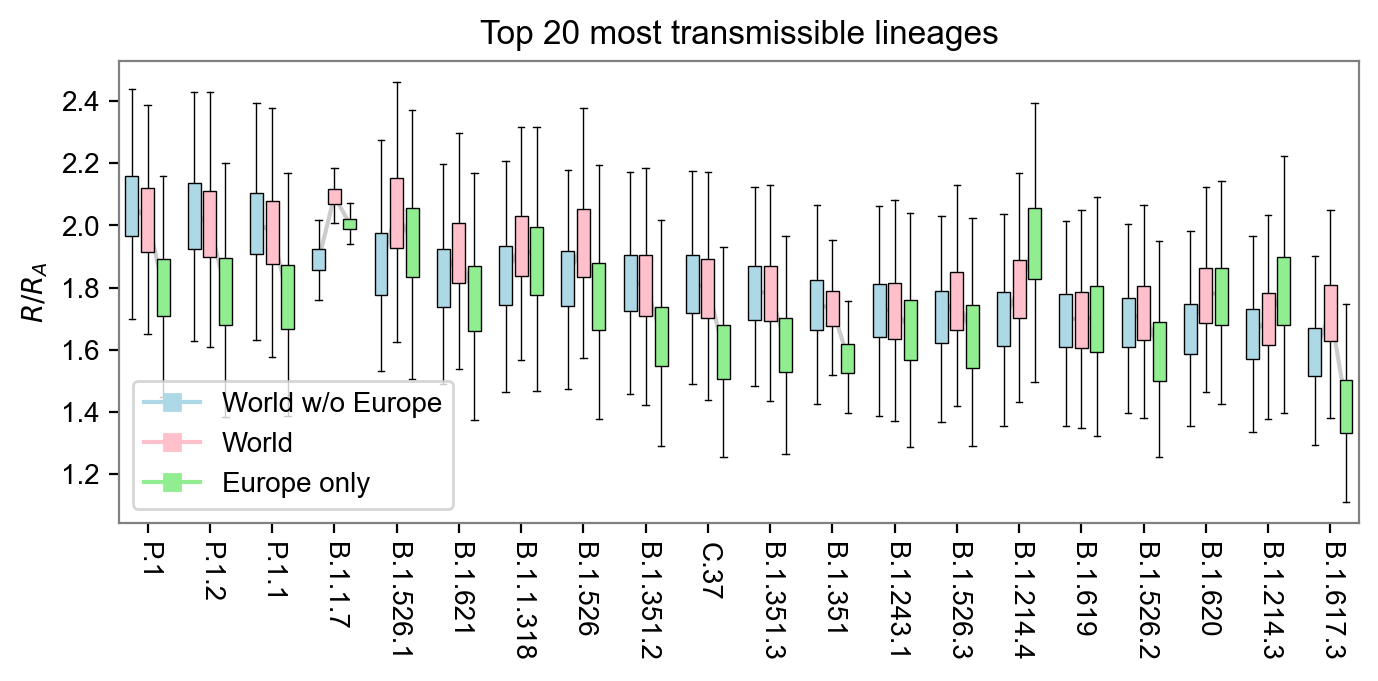

In [36]:
def plot_strain_subset_boxplot(fits, top_k=20, filenames=()):
    def get_rate(stats):
        rate = stats["rate"]
        if rate.dim() == 2:
            rate = rate.median(0).values
        return rate
    best_fit = next(iter(fits.values()))
    top_indices = get_rate(best_fit["median"]).sort(0, descending=True).indices[:top_k]
    top_lineages = [lineage_id_inv[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        mean = get_rate(fit["median"])[top_indices]
        std = get_rate(fit["std"])[top_indices]
        samples = dist.Normal(mean, std).sample((1000,))
        samples = samples - get_rate(fit["median"])[lineage_id["A"]]
        samples = samples.exp()
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean()
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]

    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 10})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               labels=top_lineages, rotation=-90)
    plt.ylabel("$R / R_A$")
    plt.title(f"Top {top_k} most transmissible lineages")
    for f in filenames:
        plt.savefig(f)

for name in ["Europe"]:
    name_ = name.lower().replace(" ", "_")
    plot_strain_subset_boxplot({
        f"World w/o {name}": holdout_fits[f"excluding {name}"],
        "World": best_fit,
        f"{name} only": holdout_fits[f"only {name}"],
    }, filenames=[f"paper/strain_{name_}_boxplot.png"])